# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data


Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [ ]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [ ]:
data = pd.read_csv('train.csv')

In [ ]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [ ]:
def process_na(df):
  print(df.isna().any(axis = None))
  df = df.fillna("")
  print(df.isna().any(axis = None))
  return df

print("Train: ")
train = process_na(train)
print("\nTest: ")
test = process_na(test)

Train: 
True
False

Test: 
True
False


## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?


In [ ]:
train[["target"]].value_counts()

target
0         3024
1         2305
dtype: int64

2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

In [ ]:
from collections import Counter
keywords = train.keyword
keywords = keywords[keywords != '']
popular_keywords = Counter(keywords).most_common(10)
print(popular_keywords)
popular_keywords = [ result[0] for result in popular_keywords ]
popular_keywords

[('damage', 36), ('siren', 35), ('wreckage', 34), ('fatalities', 33), ('deluge', 31), ('nuclear%20reactor', 30), ('emergency', 30), ('derail', 30), ('harm', 30), ('twister', 30)]


['damage',
 'siren',
 'wreckage',
 'fatalities',
 'deluge',
 'nuclear%20reactor',
 'emergency',
 'derail',
 'harm',
 'twister']

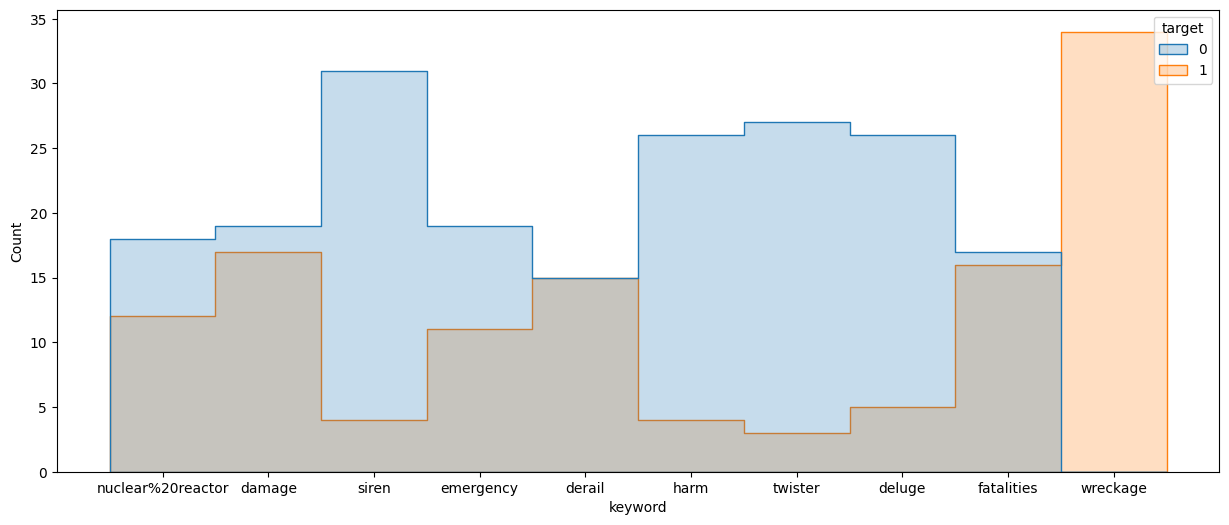

In [ ]:
plt.figure(figsize = (15, 6))
sns.histplot(train[train.keyword.isin(popular_keywords)], x="keyword", hue="target", element="step")
plt.show()

**Выводы**: \
Для большинства категорий ложных сообщений больше, чем верных. Тем не менее в категории "wreckage" все сообщения были верными, а в категории "derail" сообщения разделились поровну. В остальных категориях ложных сообщений было больше, чем верных: в некоторых категориях ("nuclear%20reactor", "damage", "fatalities") лишь незначительно, в то время как в категориях "siren", "harm", "twister" и "deluge" почти все сообщения были ложными.

## Задание 3 (0.5 балла)

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [ ]:
train.loc[[6590, 7122, 2769]]

,id,keyword,location,text,target
6590,9436,survivors,"Marietta, GA",Stemming from my #Cubs talk- the team rosters ...,1
7122,10203,violent%20storm,,If you were the NWS wth a rotating storm w/ a ...,1
2769,3980,devastation,Atlanta g.a.,http://t.co/Gxgm1T3W0J From Devastation to Ela...,0


In [ ]:
def combine_fields(df):
  df = df.copy()
  df.text = df.keyword + ' ' + df.location + ' ' + df.text
  return df[["text", "target"]]

train = combine_fields(train)
test = combine_fields(test)

In [ ]:
train.loc[[6590, 7122, 2769]]

,text,target
6590,"survivors Marietta, GA Stemming from my #Cubs ...",1
7122,violent%20storm If you were the NWS wth a rot...,1
2769,devastation Atlanta g.a. http://t.co/Gxgm1T3W0...,0


## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit_transform(train.text).shape

(5329, 18455)

## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось?

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [ ]:
def contains_digit(s: str) -> bool:
    # Проверка, содержит ли слово цифры
    return any(char.isdigit() for char in s)

from string import punctuation
def contains_punctuation(s: str) -> bool:
    # Проверка, содержит ли слово пунктуацию
    return any(char in s for char in punctuation)

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    return s[0] == '#'

def is_mention(s: str) -> bool:
    # Проверка, является ли слово упоминанием
    return s[0] == '@'

def investigate_vocabulary(vocabulary):
    words = list(vocabulary.keys())
    print('With digit:      ', np.vectorize(contains_digit)(words).sum())
    print('With punctuation:', np.vectorize(contains_punctuation)(words).sum())
    print('Hashtags:        ', np.vectorize(is_hashtag)(words).sum())
    print('Mentions:        ', np.vectorize(is_mention)(words).sum())

In [ ]:
dummy_vocab = {'th1nk' : 0,
               'think333' : 1,
               'think.' : 2,
               'th!nk' : 3,
               'th...nk' : 4,
               '#think' : 5,
               '@think' : 6,
               '@thinking':7,
               '@nothink' : 8,
               'think' : 9}
investigate_vocabulary(dummy_vocab)

With digit:       2
With punctuation: 7
Hashtags:         1
Mentions:         3


In [ ]:
investigate_vocabulary(vectorizer.vocabulary_)

With digit:       3812
With punctuation: 315
Hashtags:         0
Mentions:         0


## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [ ]:
from nltk.tokenize import TweetTokenizer
# Чтобы узнать, какие параметры есть у этого токенайзера - используйте help(TweetTokenizer)
# Для того, чтобы передать токенайзер в CountVectorizer используйте параметр tokenizer

In [ ]:
vectorizer = CountVectorizer(tokenizer = TweetTokenizer().tokenize)
vectorizer.fit_transform(train.text).shape

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(5329, 19670)

In [ ]:
investigate_vocabulary(vectorizer.vocabulary_)

With digit:       3939
With punctuation: 7338
Hashtags:         1470
Mentions:         1679


**Сравнение:** при использовании TweetTokenizer слов всех категорий стало больше. В частности, TweetTokenizer лучше выделил хэштеги и упоминания, которые не были найдены вовсе при использовании CountVectorizer без токенизатора. Слов с пунктуацией также стало больше, что свидетельствует о более корректном разделении текстов на слова: единые конструкции, содержащие в себе символы пунктуации (ссылки, хэштеги, упоминания и др.) не были разделены на не имеющие смысла части.

## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно:

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer



In [ ]:
import nltk as nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

latin_letters = [ chr(code) for code in range(ord('a'), ord('z') + 1) ]
def contains_only_latin_letters(s: str) -> bool:
    # Проверка, содержит ли слово только латинские буквы
    return all(char in latin_letters for char in s)

brackets = [ ')', '(', ']', '[', '}', '{', '>', '<' ]
def is_emoji(s: str) -> bool:
    # Проверка, является ли слово смайликом
    return all(char in punctuation for char in s) and any(char in s for char in brackets)

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    return s[0] == '#' and contains_only_latin_letters(s[1:])

stop_words = stopwords.words('english')
def custom_tokenizer(s: str) -> List[str]:
    # Кастомный токенайзер
    tokens = np.array(TweetTokenizer().tokenize(s.lower()))
    mask = (
            np.vectorize(contains_only_latin_letters)(tokens) |
            np.vectorize(is_emoji)(tokens) |
            np.vectorize(is_hashtag)(tokens)
          ) & ~np.isin(tokens, stop_words)
    return np.vectorize(SnowballStemmer("english").stem)(tokens[mask]).tolist()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
custom_tokenizer('She LOVES painting :-) #art')

['love', 'paint', ':-)', '#art']

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [ ]:
for text in train.head(10).text:
  print(text)

bridge%20collapse  Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0
hail Carol Stream, Illinois GREAT MICHIGAN TECHNIQUE CAMP
B1G THANKS TO @bmurph1019 
@hail_Youtsey . @termn8r13 
#GoBlue #WrestleOn http://t.co/OasKgki6Qj
police Houston  CNN: Tennessee movie theater shooting suspect killed by police http://t.co/dI8ElZsWNR
rioting  Still rioting in a couple of hours left until I have to be up for class.
wounds Lake Highlands Crack in the path where I wiped out this morning during beach run. Surface wounds on left elbow and right knee. http://t.co/yaqRSximph
airplane%20accident Somewhere Out There Experts in France begin examining airplane debris found on Reunion Island: French air accident experts on... http://t.co/TagZbcXFj0 #MLB
bloody Isolated City In World Perth 'I came to kill Indians...for FUN': Video of smirking and remorseless Pakistani killer shows him boasting. http://t.co/FPjLwOXKlg
bur

In [ ]:
for text in train.head(10).text:
  print(custom_tokenizer(text))

['bridg', 'ash', 'australia', 'collaps', 'trent', 'bridg', 'among', 'worst', 'histori', 'england', 'bundl', 'australia']
['hail', 'carol', 'stream', 'illinoi', 'great', 'michigan', 'techniqu', 'camp', 'thank', '#goblu', '#wrestleon']
['polic', 'houston', 'cnn', 'tennesse', 'movi', 'theater', 'shoot', 'suspect', 'kill', 'polic']
['riot', 'still', 'riot', 'coupl', 'hour', 'left', 'class']
['wound', 'lake', 'highland', 'crack', 'path', 'wipe', 'morn', 'beach', 'run', 'surfac', 'wound', 'left', 'elbow', 'right', 'knee']
['airplan', 'somewher', 'expert', 'franc', 'begin', 'examin', 'airplan', 'debri', 'found', 'reunion', 'island', 'french', 'air', 'accid', 'expert', '#mlb']
['bloodi', 'isol', 'citi', 'world', 'perth', 'came', 'kill', 'indian', 'fun', 'video', 'smirk', 'remorseless', 'pakistani', 'killer', 'show', 'boast']
['burn', 'except', 'idk', 'realli', 'burn']
['destroy', '(', 'ask', ')', 'destroy', 'hous']
['wound', 'maracay', 'nirgua', 'venezuela', 'polic', 'offic', 'wound', 'suspect

## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.


In [ ]:
vectorizer = CountVectorizer(tokenizer = custom_tokenizer)
X_train = vectorizer.fit_transform(train.text)
X_test = vectorizer.transform(test.text)

2. Обучите LogisticRegression на полученных признаках.


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model = LogisticRegression()
model.fit(X_train, train.target)

LogisticRegression()

3. Посчитайте метрику f1-score на тестовых данных.

In [ ]:
from sklearn.metrics import f1_score
predict = model.predict(X_test)
f1_score(test.target, predict)

0.7502691065662002

## Задание 9 (1 балл)

1. Повторите 8 задание, но с tf-idf векторизатором. Как изменилось качество?


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(tokenizer = custom_tokenizer)
X_train = vectorizer.fit_transform(train.text)
X_test = vectorizer.transform(test.text)
print(X_train.shape)

model = LogisticRegression()
model.fit(X_train, train.target)
predict = model.predict(X_test)
f1_score(test.target, predict)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(5329, 10492)


0.7413600891861761

1. **Ответ:** качество уменьшилось, хотя и не очень сильно


2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(tokenizer = custom_tokenizer, max_df = 0.9)
X_train = vectorizer.fit_transform(train.text)
X_test = vectorizer.transform(test.text)
print(X_train.shape)

model = LogisticRegression()
model.fit(X_train, train.target)
predict = model.predict(X_test)
f1_score(test.target, predict)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(5329, 10492)


0.7413600891861761

2. **Ответ:** ничего не изменилось

3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества?

In [ ]:
vectorizer = TfidfVectorizer(tokenizer = custom_tokenizer, min_df = 0.0003)
X_train = vectorizer.fit_transform(train.text)
X_test = vectorizer.transform(test.text)

model = LogisticRegression()
model.fit(X_train, train.target)
predict = model.predict(X_test)
f1_score(test.target, predict)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.7444444444444446

3. **Ответ:** удалось добиться незначительного улучшения по сравнению с tf-idf векторизатором без параметром, но логистическая регрессия всё равно даёт более высокую метрику f1-score при использовании CountVectorizer

## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 8 с HashingVectorizer, укажите количество фичей равное 5000.


In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer

vectorizer = HashingVectorizer(tokenizer = custom_tokenizer, n_features = 5000)
X_train = vectorizer.fit_transform(train.text)
X_test = vectorizer.transform(test.text)

model = LogisticRegression()
model.fit(X_train, train.target)
predict = model.predict(X_test)
f1_score(test.target, predict)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.720489977728285

2. Какой из подходов показал самый высокий результат?

2. **Ответ:** CountVectorizer, применённый в задании 8

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

In [ ]:
vectorizer = CountVectorizer(tokenizer = custom_tokenizer)
X_train = vectorizer.fit_transform(train.text)
X_test = vectorizer.transform(test.text)

model = LogisticRegression()
model.fit(X_train, train.target)
predict = model.predict(X_test)
f1_score(test.target, predict)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.7502691065662002